# Pets Multi Categorical Model

Here we are going to predict pets with multi categories.

In [4]:
from fastai2.vision.all import *
from utils import *

## Load Data

In [5]:
## Load data
im_path = untar_data(URLs.PETS)

In [6]:
im_path.ls()

(#2) [Path('/storage/data/oxford-iiit-pet/annotations'),Path('/storage/data/oxford-iiit-pet/images')]

In [7]:
(im_path/"images").ls()

(#7393) [Path('/storage/data/oxford-iiit-pet/images/Ragdoll_197.jpg'),Path('/storage/data/oxford-iiit-pet/images/newfoundland_36.jpg'),Path('/storage/data/oxford-iiit-pet/images/boxer_107.jpg'),Path('/storage/data/oxford-iiit-pet/images/scottish_terrier_5.jpg'),Path('/storage/data/oxford-iiit-pet/images/yorkshire_terrier_136.jpg'),Path('/storage/data/oxford-iiit-pet/images/keeshond_21.jpg'),Path('/storage/data/oxford-iiit-pet/images/beagle_188.jpg'),Path('/storage/data/oxford-iiit-pet/images/chihuahua_139.jpg'),Path('/storage/data/oxford-iiit-pet/images/basset_hound_44.jpg'),Path('/storage/data/oxford-iiit-pet/images/Russian_Blue_135.jpg')...]

In [27]:
def get_category_from_pets_image_path(p):
    return re.sub("_.*", "", p.name)

In [40]:
db = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=get_category_from_pets_image_path,
    splitter=RandomSplitter(0.3),
    # This is presizing
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

In [41]:
dls = db.dataloaders(im_path/"images")

## Presizing

This is a very interesting augmentation method. Here we will resize the item to a bigger resolution of 460px. This happens inside the **CPU**.
Then we will do a set of augmentations inside the **GPU** with pixel size of **224px.**

By doing this, we can acheive good resolution even for the augmented images.

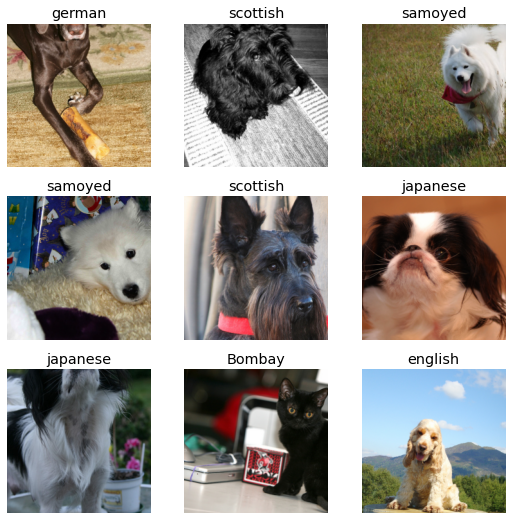

In [39]:
dls.show_batch()

## Training

In [45]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)

In [46]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,time
0,1.624902,0.315104,0.892197,01:14


epoch,train_loss,valid_loss,accuracy,time
0,0.503341,0.251662,0.914299,01:37


As you can see, we got a really good accuracy for these categories even with a first try without doing any data cleaning or optimization.

Doing those optimizations is not the idea of this model but to understand what's going inside.

## Loss Function

`cnn_learner` can detect a related loss function automatically. Let's try to find what it is in this case

In [47]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [53]:
doc(learn.loss_func)

We are going to learn a bit more about this in the next notebook.

## Dig the Dataset

In [58]:
x, y = dls.one_batch()

In [61]:
x.shape, y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

**We have 64 items in this batch.**

In [67]:
## This shows the number of categories in our dataset.
dls.vocab

(#35) ['Abyssinian','Bengal','Birman','Bombay','British','Egyptian','Maine','Persian','Ragdoll','Russian'...]

In [76]:
## You can see those here from the y
y.sort().values

tensor([ 0,  0,  2,  2,  2,  3,  3,  5,  5,  6,  6,  6,  7,  8,  9,  9, 10, 12, 12, 13, 13, 13, 14, 14, 17, 17, 17, 17, 17, 18, 20, 21, 21, 21, 21, 22, 23, 23, 23, 23, 24, 24, 25, 25, 25, 25, 26, 26,
        27, 27, 27, 27, 28, 30, 31, 31, 32, 32, 33, 33, 34, 34, 34, 34], device='cuda:0')

In [157]:
## X contains a RGB image
print(x[0].shape)

torch.Size([3, 224, 224])


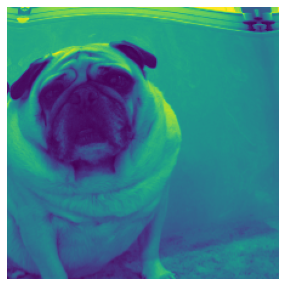

In [156]:
## This is how a single channel looks like
show_image(x[0][0])

## Predictions

In [139]:
preds,_ = learn.get_preds(dl=[(x,)])

In [135]:
preds.shape

torch.Size([64, 35])

Each prediction has 35 values. That related to the number of categories in this dataset.

In [158]:
preds[0]

tensor([1.6380e-06, 2.6136e-06, 3.7904e-07, 6.3720e-07, 3.5927e-06, 7.3331e-06, 2.1690e-06, 9.5507e-06, 1.6104e-06, 9.1579e-06, 2.2213e-04, 2.7832e-05, 2.2388e-04, 3.6801e-05, 3.7764e-06, 1.2768e-04,
        1.6071e-06, 1.2828e-06, 2.7765e-06, 8.3203e-06, 1.8087e-05, 2.7198e-05, 4.3600e-06, 2.2848e-05, 4.1735e-07, 7.9722e-06, 7.8034e-08, 9.9906e-01, 1.2917e-04, 6.0394e-07, 3.6039e-06, 1.6699e-06,
        4.7882e-06, 1.1770e-05, 8.9233e-06])

In [159]:
preds[0].sum()

tensor(1.)

**So clearly this is a set of probabilities for each 35 categories**

In [161]:
preds[0].sort(descending=True)

torch.return_types.sort(
values=tensor([9.9906e-01, 2.2388e-04, 2.2213e-04, 1.2917e-04, 1.2768e-04, 3.6801e-05, 2.7832e-05, 2.7198e-05, 2.2848e-05, 1.8087e-05, 1.1770e-05, 9.5507e-06, 9.1579e-06, 8.9233e-06, 8.3203e-06, 7.9722e-06,
        7.3331e-06, 4.7882e-06, 4.3600e-06, 3.7764e-06, 3.6039e-06, 3.5927e-06, 2.7765e-06, 2.6136e-06, 2.1690e-06, 1.6699e-06, 1.6380e-06, 1.6104e-06, 1.6071e-06, 1.2828e-06, 6.3720e-07, 6.0394e-07,
        4.1735e-07, 3.7904e-07, 7.8034e-08]),
indices=tensor([27, 12, 10, 28, 15, 13, 11, 21, 23, 20, 33,  7,  9, 34, 19, 25,  5, 32, 22, 14, 30,  4, 18,  1,  6, 31,  0,  8, 16, 17,  3, 29, 24,  2, 26]))

It seems like category 27 is the winner.

In [162]:
dls.vocab[27]

'pug'

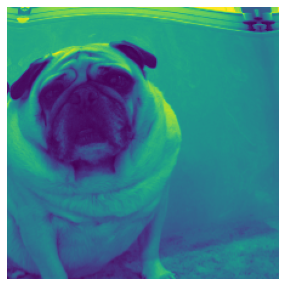

In [164]:
show_image(x[0][0])

**Yeah, that's a pug**